### LSTM 을 활용한 주가 예측 모델
##### Tensorflow Dataset 클래스를 활용하여 주가 데이터 구축

### 필요한 모듈 import 및 데이터 가져오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

In [101]:
df = pd.read_csv("현대홈쇼핑.csv")
df_columns = ['Date','Open', 'High', 'Low', 'Close', 'Volume']
df.columns = df_columns

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Date    600 non-null    int64
 1   Open    600 non-null    int64
 2   High    600 non-null    int64
 3   Low     600 non-null    int64
 4   Close   600 non-null    int64
 5   Volume  600 non-null    int64
dtypes: int64(6)
memory usage: 28.2 KB


In [103]:
df

,Date,Open,High,Low,Close,Volume
0,20220516,58000,58000,57000,57200,11116
1,20220513,57000,57900,56600,57500,14665
2,20220512,56900,57400,56500,56600,28071
3,20220511,57000,58300,57000,57700,16394
4,20220510,56900,57600,56400,57000,25686
...,...,...,...,...,...,...
595,20191216,80100,80100,79700,79800,20897
596,20191213,80000,81300,79600,79700,44711
597,20191212,80400,80600,79600,80000,61253
598,20191211,80200,80500,79700,80200,18290


In [104]:
#시간순으로 정렬(시계열 데이터이므로 일단 시간순으로 정리)
df = df.sort_values('Date')
df

,Date,Open,High,Low,Close,Volume
599,20191210,79900,80700,78800,80200,25870
598,20191211,80200,80500,79700,80200,18290
597,20191212,80400,80600,79600,80000,61253
596,20191213,80000,81300,79600,79700,44711
595,20191216,80100,80100,79700,79800,20897
...,...,...,...,...,...,...
4,20220510,56900,57600,56400,57000,25686
3,20220511,57000,58300,57000,57700,16394
2,20220512,56900,57400,56500,56600,28071
1,20220513,57000,57900,56600,57500,14665


In [105]:
##날짜 형식 지정해주기위해 str로 변경(원래는 int64로 되어있음)
df['Date']= df['Date'].astype('str')
from datetime import datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df

,Open,High,Low,Close,Volume
Date,,,,,
2019-12-10,79900,80700,78800,80200,25870
2019-12-11,80200,80500,79700,80200,18290
2019-12-12,80400,80600,79600,80000,61253
2019-12-13,80000,81300,79600,79700,44711
2019-12-16,80100,80100,79700,79800,20897
...,...,...,...,...,...
2022-05-10,56900,57600,56400,57000,25686
2022-05-11,57000,58300,57000,57700,16394
2022-05-12,56900,57400,56500,56600,28071


### 시각화

Text(0, 0.5, 'price')

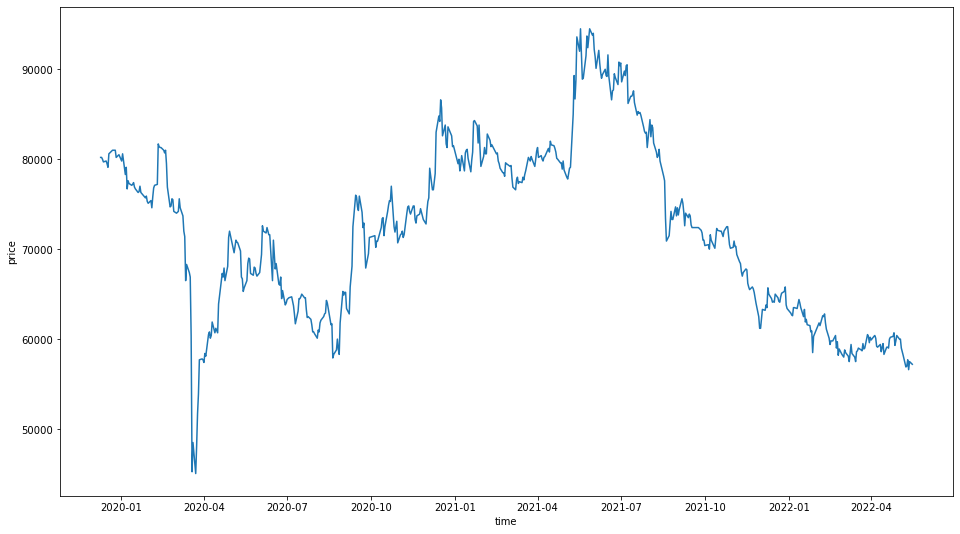

In [106]:
###종가의 시간에 따른 값 변화 확인

plt.figure(figsize=(16, 9))   #그림 사이즈 조정
sns.lineplot(y=df['Close'], x=df.index)  #,x,y축 설정
plt.xlabel('time')  #x축 레이블 이름 지정
plt.ylabel('price')  #y축 레이블 이름 지정


### 데이터 전처리
##### 주가데이터에 대해 딥러닝 모델이 더 잘 학습할 수 있도록 정규화 시켜줌
###### (모든 데이터가 0 ~ 1 사이의 값)
##### 표준화는 sklearn.preprocesssing 에 StandardScaler로 표준화 시켜줌

In [107]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 정규화시킬 column을 정의
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])
scaled #(0~1값을 가지는 것을 볼 수 있음)

array([[0.69833497, 0.69684639, 0.70873786, 0.71081901, 0.10293137],
       [0.70421156, 0.69277721, 0.72621359, 0.71081901, 0.06376371],
       [0.70812929, 0.6948118 , 0.72427184, 0.70677452, 0.28576374],
       ...,
       [0.24779628, 0.22278739, 0.27572816, 0.23356926, 0.11430446],
       [0.24975514, 0.23296033, 0.2776699 , 0.25176946, 0.04503248],
       [0.26934378, 0.23499491, 0.28543689, 0.24570273, 0.02669395]])

In [108]:
df = pd.DataFrame(scaled, columns=scale_cols)
df
##600개의 row, 5개의 column으로 구성되어있음, 시간순으로 정리되어있음

,Open,High,Low,Close,Volume
0,0.698335,0.696846,0.708738,0.710819,0.102931
1,0.704212,0.692777,0.726214,0.710819,0.063764
2,0.708129,0.694812,0.724272,0.706775,0.285764
3,0.700294,0.709054,0.724272,0.700708,0.200287
4,0.702253,0.684639,0.726214,0.702730,0.077235
...,...,...,...,...,...
595,0.247796,0.226857,0.273786,0.241658,0.101981
596,0.249755,0.241099,0.285437,0.255814,0.053967
597,0.247796,0.222787,0.275728,0.233569,0.114304
598,0.249755,0.232960,0.277670,0.251769,0.045032


### train / test 분할

##### 모델링할때 train set, test set(validation set) 구분해야함
##### 하나하나 코드를 작성할 수도 있지만 scikit-learn의 train_test_split으로 간단하게 사용가능
##### ex) train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target, random_state=34)


In [127]:
#train,test의 비율을 3:7로
from sklearn.model_selection import train_test_split
#여기서 우리가 예측해야하는게 df의 Close이므로 이게 target이 됨
#data전체는 df에서 close제외한 것 axis = 1이면 columns(0은 row) 
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.3, random_state=0, shuffle=False)

In [110]:
x_train.shape, y_train.shape

((420, 4), (420,))

In [111]:
x_test.shape, y_test.shape

((180, 4), (180,))

In [112]:
x_train

,Open,High,Low,Volume
0,0.698335,0.696846,0.708738,0.102931
1,0.704212,0.692777,0.726214,0.063764
2,0.708129,0.694812,0.724272,0.285764
3,0.700294,0.709054,0.724272,0.200287
4,0.702253,0.684639,0.726214,0.077235
...,...,...,...,...
415,0.715965,0.709054,0.741748,0.077710
416,0.725759,0.711089,0.712621,0.098451
417,0.688541,0.684639,0.691262,0.078955
418,0.651322,0.658189,0.660194,0.084665


In [113]:
y_train

0      0.710819
1      0.710819
2      0.706775
3      0.700708
4      0.702730
         ...   
415    0.729019
416    0.702730
417    0.668352
418    0.658241
419    0.573306
Name: Close, Length: 420, dtype: float64

### tensorflow dataset을 활용한 시퀀스 데이터셋 구성

In [114]:
import tensorflow as tf

###시계열 데이터 다룰때 windowed_dataset 사용하면 유용
# 시계열 데이터의 양이 방대하기때문에 한번에 올리면 메모리 과부화 생길 수 있어서 나눠서 올리게끔...?

def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

##### hyperparameter 정의

In [115]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [116]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [117]:
train_data
###열이 1이므로 일렬로..??

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [118]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있음
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


###keras에서 모델 형성에는 두가지 방법 존재 1.sequential 모델(순차적으로 레이어 층 만들어줌)
###시퀀스 데이터에 합성곱을 적용하는 이유는 데이터에 내제된 lcoal한 특징을 추출하는 역할을 한다고 볼 수 있음
## 32개의 크기5인 필터들을 사용하여 

model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           #활성화함수를 relu로 정의
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),    ##16개의 lstm 사용, 활성화함수는 역tan함수
    Dense(16, activation="relu"),   ##16개의 뉴럴넷 사용, 활성화함수는 relu함수
    Dense(1),  #마지막 값은 1개가 도출되어야 하므로 dense(1)을 추가
])

In [120]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
#시퀀셜 모델을 학습하기 전에 컴파일 먼저 해줘야함
#손실함수(loss)는 모델이 최소화할 수 있게 도와줌 
#optimizer에는 sgd,adam,rmsprop등등이 있다. metircs는 모델 성능 지표함수
loss = Huber()
optimizer = Adam(0.005) ##3compile 시 optimizer는 adam으로 사용
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])  ##regression이기 때문에 mse 사용

In [121]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
#ModelCheckpoint는 조건을 만족했을 때 Model의 weight 값을 중간 저장
#모델이 개선된 validation score를 도출해낼 때마다 weight를 중간 저장함으로써, 혹시 중간에 memory overflow나 crash가 나더라도 다시 weight를 불러와서 학습을 이어나갈 수 있기 때문에, 시간 절약
checkpoint = ModelCheckpoint(filename, #file명 지정
                             save_weights_only=True, #true 일때에는 모델 가중치만, false이면 모델 전체
                             save_best_only=True, #true이면 이전보다 성능이 좋은 경우에만 모델 저장
                             monitor='val_loss', #val_loss 기준으로 best 찾기
                             verbose=1)  #로그 출력 

In [122]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50,   #50번 학습
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
     13/Unknown - 5s 14ms/step - loss: 0.1184 - mse: 0.2368
Epoch 1: val_loss improved from inf to 0.01864, saving model to tmp\ckeckpointer.ckpt
13/13 [==============================] - 8s 297ms/step - loss: 0.1184 - mse: 0.2368 - val_loss: 0.0186 - val_mse: 0.0373
Epoch 2/50
11/13 [========================>.....] - ETA: 0s - loss: 0.0228 - mse: 0.0456
Epoch 2: val_loss did not improve from 0.01864
13/13 [==============================] - 0s 21ms/step - loss: 0.0219 - mse: 0.0437 - val_loss: 0.0192 - val_mse: 0.0384
Epoch 3/50
10/13 [======================>.......] - ETA: 0s - loss: 0.0156 - mse: 0.0312
Epoch 3: val_loss improved from 0.01864 to 0.01450, saving model to tmp\ckeckpointer.ckpt
13/13 [==============================] - 0s 27ms/step - loss: 0.0148 - mse: 0.0296 - val_loss: 0.0145 - val_mse: 0.0290
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 0.0093 - mse: 0.0187
Epoch 4: val_loss improved from 0.01450 to 0.00580, saving model to tmp\ckeckp

In [123]:
pred = model.predict(test_data)

In [124]:
pred.shape

(160, 1)

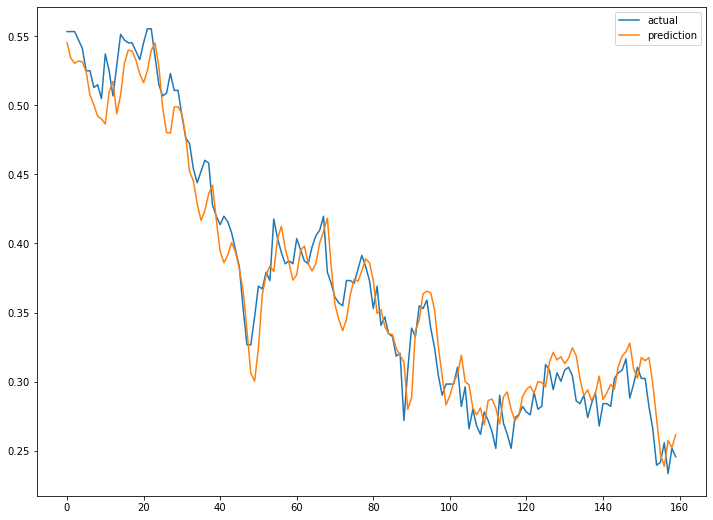

In [125]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()